### Required Python Modules and TensorFlow Components

In [2]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from PIL import Image
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model


**Tensor flow version used**

In [3]:
print(tf.__version__)

2.16.1


## Dataset Loading and Preprocessing with Visualization

In [3]:
# This is the directory where the dataset is stored on my local machine - change this to the directory where the dataset is stored on your machine
data_dir = 'C:\\Users\\ronan\\OneDrive - Atlantic TU\\Year Four\\Sem2\\Gesture Based UI\\hagridset'

print("Dataset directory:", data_dir)

Dataset directory: C:\Users\ronan\OneDrive - Atlantic TU\Year Four\Sem2\Gesture Based UI\hagridset


In [4]:
BATCH_SIZE = 32
SEED = 384824  

In [27]:
# Load the dataset with preprocessing
def load_and_preprocess_data(img_size=(256, 256), batch_size=32, val_split=0.1, test_split=0.2):
    # Calculate the split sizes
    total_val_test_split = val_split + test_split
    val_split_adjusted = val_split / total_val_test_split

    # Load the dataset with resizing and converting to grayscale
    full_dataset = image_dataset_from_directory(
        data_dir,
        validation_split=total_val_test_split,
        subset="training",
        seed=384824,  # 
        image_size=img_size,
        batch_size=batch_size,
        color_mode='grayscale')  # Set to grayscale

    # Create train, validation, test splits
    validation_and_test_dataset = image_dataset_from_directory(
        data_dir,
        validation_split=total_val_test_split,
        subset="validation",
        seed=384824,
        image_size=img_size,
        batch_size=batch_size,
        color_mode='grayscale')

    # Determine how many batches are in the validation set
    val_batches = int(len(validation_and_test_dataset) * val_split_adjusted)

    # Split the validation and test dataset
    validation_dataset = validation_and_test_dataset.take(val_batches)
    test_dataset = validation_and_test_dataset.skip(val_batches)

    return full_dataset, validation_dataset, test_dataset

# Example usage
train_dataset, val_dataset, test_dataset = load_and_preprocess_data()

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [36]:
def dataset_statistics(train_dataset, validation_dataset, test_dataset, batch_size):
    print("Number of training batches: ", len(train_dataset))
    print("Number of validation batches: ", len(validation_dataset))
    print("Number of test batches: ", len(test_dataset))
    print("Classes available: ", train_dataset.class_names)

    print("Training batch size: ", batch_size)
    print("Validation batch size: ", batch_size)
    print("Test batch size: ", batch_size)

# Assuming a batch size of 32, which you used in dataset loading
dataset_statistics(train_dataset, val_dataset, test_dataset, BATCH_SIZE)


Number of training batches:  2755
Number of validation batches:  393
Number of test batches:  788
Classes available:  ['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted', 'three', 'three2', 'two_up', 'two_up_inverted']
Training batch size:  32
Validation batch size:  32
Test batch size:  32


#### Visualization of the Dataset

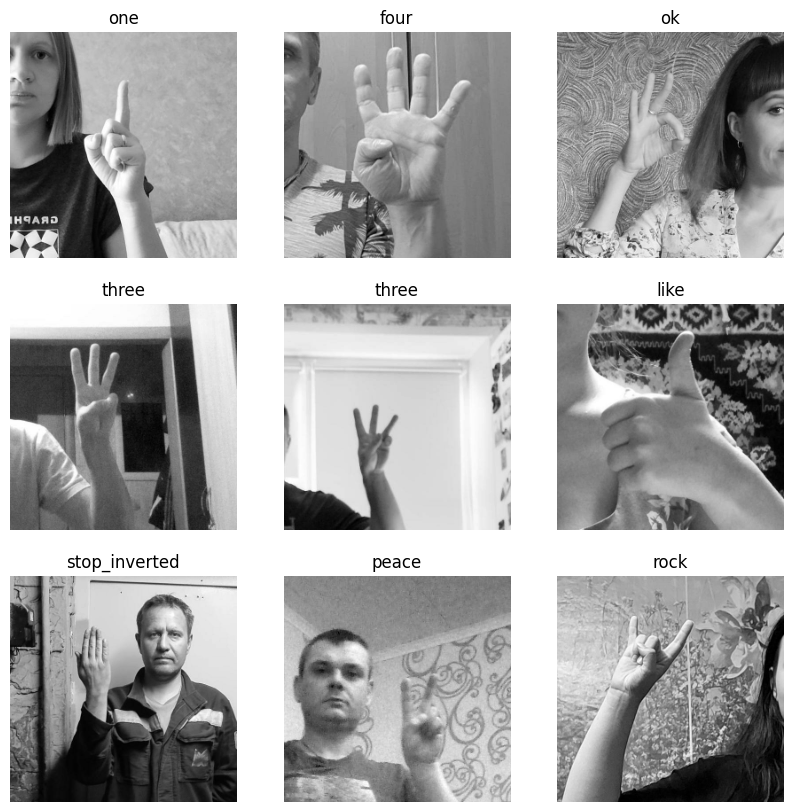

In [24]:
####  ####
# Display images and labels from the dataset
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

#### Convolutional Neural Network (CNN) Model Training and Evaluation with Visualization (GrayScale) (model 1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    33,554,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,575,698 (128.08 MB)

 Trainable params: 33,575,698 (128.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 1731s 628ms/step - accuracy: 0.1052 - loss: 2.8404 - val_accuracy: 0.2483 - val_loss: 2.3536
Epoch 2/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 1794s 651ms/step - accuracy: 0.2855 - loss: 2.2309 - val_accuracy: 0.2820 - val_loss: 2.3075
Epoch 3/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 1720s 624ms/step - accuracy: 0.4383 - loss: 1.7350 - val_accuracy: 0.2692 - val_loss: 2.7823
Epoch 4/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 1733s 629ms/step - accuracy: 0.6185 - loss: 1.1722 - val_accuracy: 0.2524 - val_loss: 3.8764
Epoch 5/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 1790s 650ms/step - accuracy: 0.7811 - loss: 0.6826 - val_accuracy: 0.2396 - val_loss: 5.2923
Epoch 6/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 1718s 624ms/step - accuracy: 0.8814 - loss: 0.3769 - val_accuracy: 0.2324 - val_loss: 6.6196
Epoch 7/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 1726s 626ms/step - accuracy: 0.9224 - loss: 0.2501 - val_accuracy: 0.2339 - val_loss: 7.6407
Epoch 8/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 1786s 648ms/s

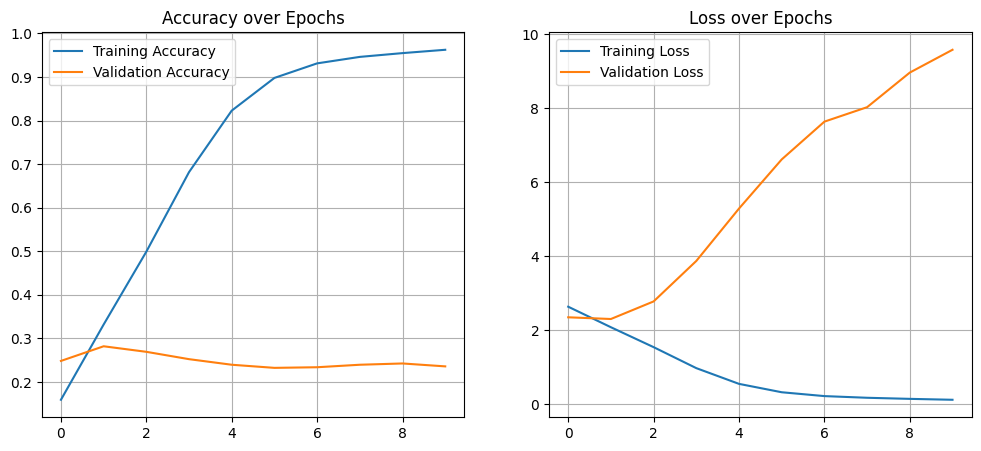

In [16]:
# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Rescaling(1./255),  # Normalize pixel values
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Assuming your image shape is (256, 256) and in grayscale, and you have 10 classes
input_shape = (256, 256, 1)  # Update based on your dataset specifics
num_classes = 18  # Update based on your dataset specifics

model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # You can adjust this based on your specific needs
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Optionally, plot the training history for accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.show()

In [17]:
# Save the entire model to a SavedModel directory
model.save('C:\\Users\\ronan\\OneDrive - Atlantic TU\\Year Four\\Sem2\\Gesture Based UI\\greyscal_model.keras')

## Dataset Loading and Preprocessing with RGB Color Mode (Downsized to 128x128) 

In [ ]:
# Load the dataset with preprocessing for color images
def load_and_preprocess_data(img_size=(128, 128), batch_size=32, val_split=0.1, test_split=0.2):
    # Calculate the split sizes
    total_val_test_split = val_split + test_split
    val_split_adjusted = val_split / total_val_test_split

    # Load the dataset with resizing and color mode set to RGB
    full_dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=total_val_test_split,
        subset="training",
        seed=384824,  
        image_size=img_size,
        batch_size=batch_size,
        color_mode='rgb')  # Set to RGB

    validation_and_test_dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=total_val_test_split,
        subset="validation",
        seed=384824,
        image_size=img_size,
        batch_size=batch_size,
        color_mode='rgb')

    # Determine how many batches are in the validation set
    val_batches = int(len(validation_and_test_dataset) * val_split_adjusted)

    # Split the validation and test dataset
    validation_dataset = validation_and_test_dataset.take(val_batches)
    test_dataset = validation_and_test_dataset.skip(val_batches)

    return full_dataset, validation_dataset, test_dataset

train_dataset, val_dataset, test_dataset = load_and_preprocess_data()

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


## Convolutional Neural Network (CNN) Model Training for Downsized Color Images (Model 2)

In [ ]:
# Define the CNN model for color images
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Rescaling(1./255),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Update based on your dataset specifics, now including 3 channels for RGB
input_shape = (128, 128, 3)
num_classes = 18  # Update based on actual number of classes

model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Adjust as needed
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 626s 227ms/step - accuracy: 0.1357 - loss: 2.7502 - val_accuracy: 0.3367 - val_loss: 2.0846
Epoch 2/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 1372s 498ms/step - accuracy: 0.3718 - loss: 1.9547 - val_accuracy: 0.4313 - val_loss: 1.7778
Epoch 3/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 571s 207ms/step - accuracy: 0.5091 - loss: 1.5090 - val_accuracy: 0.4412 - val_loss: 1.8195
Epoch 4/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 517s 187ms/step - accuracy: 0.6326 - loss: 1.1140 - val_accuracy: 0.4472 - val_loss: 2.0287
Epoch 5/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 498s 181ms/step - accuracy: 0.7373 - loss: 0.7944 - val_accuracy: 0.4332 - val_loss: 2.5518
Epoch 6/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 466s 169ms/step - accuracy: 0.8168 - loss: 0.5542 - val_accuracy: 0.4310 - val_loss: 3.1426
Epoch 7/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 1200s 436ms/step - accuracy: 0.8701 - loss: 0.3935 - val_accuracy: 0.4253 - val_loss: 3.7923
Epoch 8/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 7792s 3s/step - ac

In [ ]:
# Save the entire model to a SavedModel directory
model.save('C:\\Users\\ronan\\OneDrive - Atlantic TU\\Year Four\\Sem2\\Gesture Based UI\\colour_model.keras')

## Dataset Loading and Preprocessing with Data Augmentation for Overfitting Mitigation

In [ ]:
def load_and_preprocess_data(img_size=(128, 128), batch_size=32, val_split=0.1, test_split=0.2):
    # Data augmentation
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2)
    ])

    # Load the dataset with resizing and color mode set to RGB
    full_dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=val_split + test_split,
        subset="training",
        seed=384824,
        image_size=img_size,
        batch_size=batch_size,
        color_mode='rgb',
        label_mode='int')

    validation_and_test_dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=val_split + test_split,
        subset="validation",
        seed=384824,
        image_size=img_size,
        batch_size=batch_size,
        color_mode='rgb',
        label_mode='int')

    # Apply data augmentation
    full_dataset = full_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

    # Determine how many batches are in the validation set
    val_batches = int(len(validation_and_test_dataset) * (val_split / (val_split + test_split)))

    # Split the validation and test dataset
    validation_dataset = validation_and_test_dataset.take(val_batches)
    test_dataset = validation_and_test_dataset.skip(val_batches)

    return full_dataset, validation_dataset, test_dataset

train_dataset, val_dataset, test_dataset = load_and_preprocess_data()

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


## Convolutional Neural Network (CNN) Model Training with Dropout and Early Stopping (Model 3)

Epoch 1/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 645s 234ms/step - accuracy: 0.0629 - loss: 2.8988 - val_accuracy: 0.0879 - val_loss: 2.8571
Epoch 2/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 637s 231ms/step - accuracy: 0.0779 - loss: 2.8634 - val_accuracy: 0.1055 - val_loss: 2.8209
Epoch 3/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 643s 233ms/step - accuracy: 0.0902 - loss: 2.8397 - val_accuracy: 0.1240 - val_loss: 2.7758
Epoch 4/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 624s 227ms/step - accuracy: 0.1018 - loss: 2.8166 - val_accuracy: 0.1468 - val_loss: 2.7137
Epoch 5/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 630s 229ms/step - accuracy: 0.1148 - loss: 2.7881 - val_accuracy: 0.1556 - val_loss: 2.6879
Epoch 6/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 618s 224ms/step - accuracy: 0.1194 - loss: 2.7681 - val_accuracy: 0.1644 - val_loss: 2.6713
Epoch 7/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 641s 233ms/step - accuracy: 0.1260 - loss: 2.7512 - val_accuracy: 0.1837 - val_loss: 2.6082
Epoch 8/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 713s 259ms/step - ac

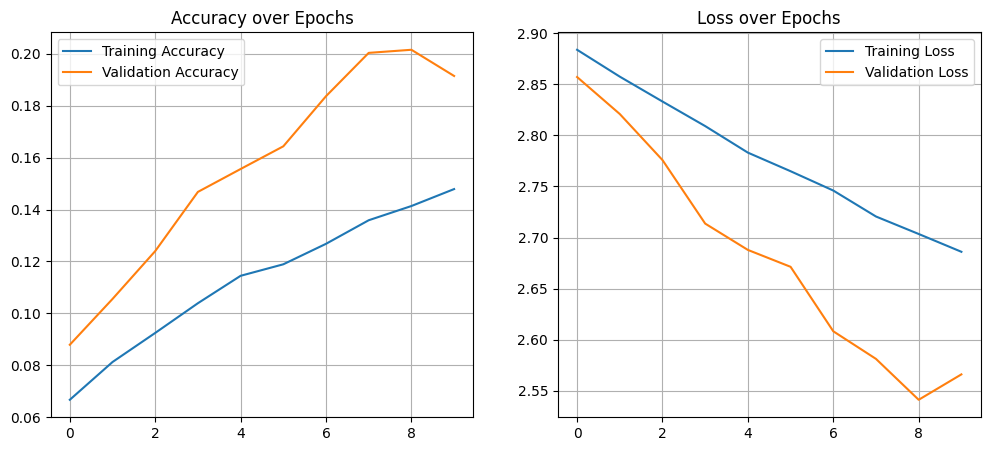

In [ ]:
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Rescaling(1./255),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),  # Dropout added here
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Another Dropout
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (128, 128, 3)  # RGB images
num_classes = 18  # Adjusted to your dataset specifics

model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Setup Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with Early Stopping
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
model.save('C:\\Users\\ronan\\OneDrive - Atlantic TU\\Year Four\\Sem2\\Gesture Based UI\\colour_overfift_model.keras')

## CNN Model Training with Increased Complexity and Early Stopping (Model 4)

In [ ]:
# Define constants to make it easier from now on
IMAGE_SIZE = (128, 128)  # Use an image size of 128x128
BATCH_SIZE = 32
SEED = 384824  

# Load the dataset with the specified splits for training and validation/testing
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=IMAGE_SIZE,
    validation_split=0.3,
    subset='training',
    label_mode='categorical',
    seed=SEED,
    batch_size=BATCH_SIZE
)

validation_and_test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=IMAGE_SIZE,
    validation_split=0.3,
    subset='validation',
    label_mode='categorical',
    seed=SEED,
    batch_size=BATCH_SIZE
)

# Calculate the number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(validation_and_test_dataset)

# Split the validation and test datasets
test_dataset = validation_and_test_dataset.take((2 * val_batches) // 3)
validation_dataset = validation_and_test_dataset.skip((2 * val_batches) // 3)

# Get the number of classes from the dataset
NUM_CLASSES = len(train_dataset.class_names)

# CNN model with increased complexity
model = models.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),  # Increased filter size
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),  # Additional layer with more filters
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),  # Increased dense layer size
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Model summary
model.summary()

# Configure early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[early_stopping]
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,834 (1.75 MB)

 Trainable params: 458,834 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 755s 273ms/step - accuracy: 0.1067 - loss: 2.7371 - val_accuracy: 0.3633 - val_loss: 1.8835
Epoch 2/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 769s 279ms/step - accuracy: 0.4850 - loss: 1.5480 - val_accuracy: 0.7002 - val_loss: 0.9350
Epoch 3/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 680s 247ms/step - accuracy: 0.7257 - loss: 0.8551 - val_accuracy: 0.7821 - val_loss: 0.6885
Epoch 4/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 660s 239ms/step - accuracy: 0.8131 - loss: 0.5844 - val_accuracy: 0.8331 - val_loss: 0.5423
Epoch 5/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 664s 241ms/step - accuracy: 0.8557 - loss: 0.4474 - val_accuracy: 0.8440 - val_loss: 0.5092
Epoch 6/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 674s 244ms/step - accuracy: 0.8858 - loss: 0.3524 - val_accuracy: 0.8689 - val_loss: 0.4223
Epoch 7/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 679s 246ms/step - accuracy: 0.9048 - loss: 0.2900 - val_accuracy: 0.8746 - val_loss: 0.4132
Epoch 8/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 759s 275ms/step - ac

In [ ]:
model.save('C:\\Users\\ronan\\OneDrive - Atlantic TU\\Year Four\\Sem2\\Gesture Based UI\\colour_overfift_complexity_model.keras')

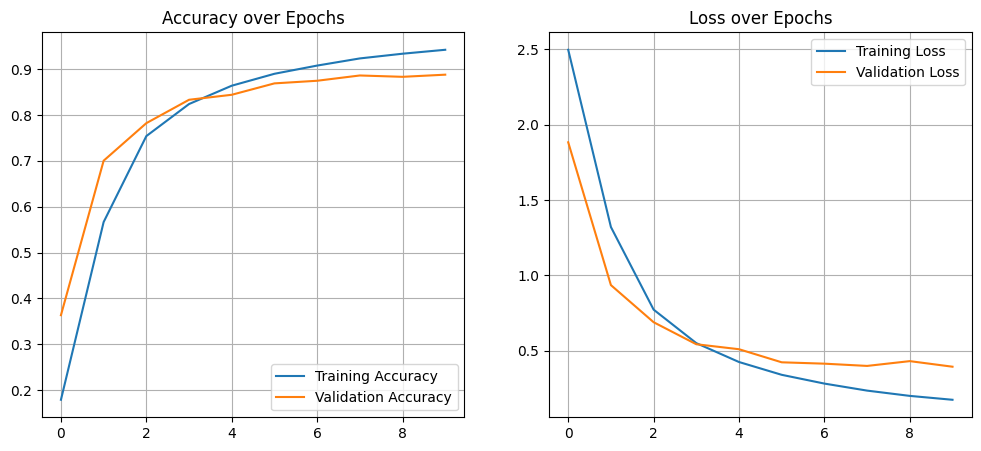

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.show()

## Enhanced CNN with Unique Data Augmentation and Increased Complexity (Model 5)

In [ ]:
IMAGE_SIZE = (128, 128)  # Use an image size of 128x128

In [ ]:
# Load the dataset with the specified splits for training and validation/testing
train_dataset = tf.keras.utils.image_dataset_from_directory(
     data_dir,
    shuffle=True,
    image_size=IMAGE_SIZE,
    validation_split=0.3,
    subset='training',
    label_mode='categorical',
    seed=SEED,
    batch_size=BATCH_SIZE
)

validation_and_test_dataset = tf.keras.utils.image_dataset_from_directory(
     data_dir,
    shuffle=True,
    image_size=IMAGE_SIZE,
    validation_split=0.3,
    subset='validation',
    label_mode='categorical',
    seed=SEED,
    batch_size=BATCH_SIZE
)

# Calculate the number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(validation_and_test_dataset)

# Split the validation and test datasets
test_dataset = validation_and_test_dataset.take((2 * val_batches) // 3)
validation_dataset = validation_and_test_dataset.skip((2 * val_batches) // 3)

# Get the number of classes from the dataset
NUM_CLASSES = len(train_dataset.class_names)

# Enhanced CNN model with data augmentation
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  
    tf.keras.layers.RandomRotation(0.2),                    
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),  # Enhanced complexity
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),  # Further complexity
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),  # Increased size of dense layer
    layers.Dense(NUM_CLASSES, activation='softmax')
])


# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Model summary to display the architecture
model.summary()

# Configure early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[early_stopping]
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")



Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


c:\Users\ronan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,634 (1.62 MB)

 Trainable params: 423,634 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 698s 253ms/step - accuracy: 0.0628 - loss: 2.8824 - val_accuracy: 0.0771 - val_loss: 2.8420
Epoch 2/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 785s 285ms/step - accuracy: 0.0809 - loss: 2.8460 - val_accuracy: 0.0898 - val_loss: 2.8174
Epoch 3/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 683s 248ms/step - accuracy: 0.0913 - loss: 2.8154 - val_accuracy: 0.1200 - val_loss: 2.7200
Epoch 4/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 678s 246ms/step - accuracy: 0.1183 - loss: 2.7278 - val_accuracy: 0.1578 - val_loss: 2.5850
Epoch 5/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 677s 246ms/step - accuracy: 0.1615 - loss: 2.5937 - val_accuracy: 0.2145 - val_loss: 2.4228
Epoch 6/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 721s 262ms/step - accuracy: 0.2167 - loss: 2.4425 - val_accuracy: 0.2751 - val_loss: 2.2225
Epoch 7/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 687s 249ms/step - accuracy: 0.2834 - loss: 2.2298 - val_accuracy: 0.3458 - val_loss: 1.9979
Epoch 8/10
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 792s 287ms/step - ac

In [37]:
model.save('C:\\Users\\ronan\\OneDrive - Atlantic TU\\Year Four\\Sem2\\Gesture Based UI\\colour_Data_Augmentation_and_Increased_Complexity_model.keras')

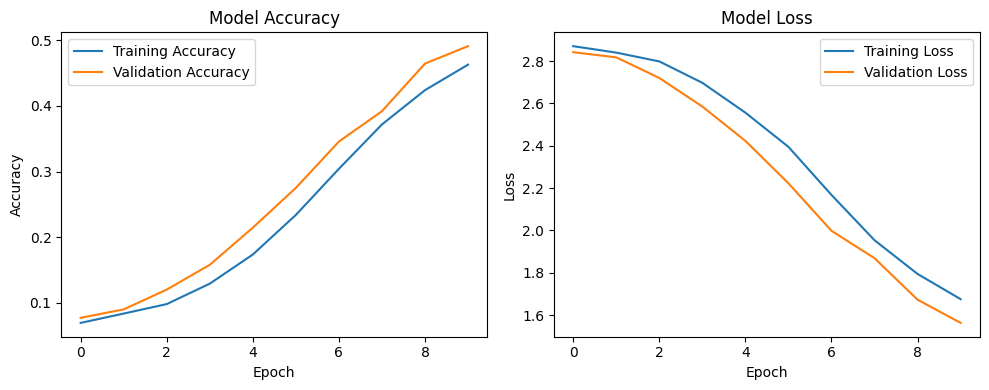

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Data loading and Setup Data Augmentation and Generators

In [16]:
data_dir = 'C:\\Users\\ronan\\OneDrive - Atlantic TU\\Year Four\\Sem2\\Gesture Based UI\\hagridset'
BATCH_SIZE = 32
SEED = 384824  

In [17]:
# Setup the ImageDataGenerator with the augmentation options
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of data for validation
)

# Prepare the training and validation generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),  # New image size
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),  # New image size
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

Found 100737 images belonging to 18 classes.
Found 25175 images belonging to 18 classes.


## Load and Configure the VGG16 Model with Augmentation (Model 1)

In [18]:
# Load the VGG16 model, pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))

# Freeze the convolutional base
base_model.trainable = False

# Create a new model on top
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(18, activation='softmax')(x)  # Ensure this matches the number of classes in your dataset

# This is the model that will be trained
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

# Evaluate the model
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"Final validation accuracy: {final_val_accuracy*100:.2f}%, Final validation loss: {final_val_loss:.2f}")

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 18)             │        18,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,258,450 (58.21 MB)

 Trainable params: 543,762 (2.07 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 5041s 2s/step - accuracy: 0.1626 - loss: 2.6736 - val_accuracy: 0.3114 - val_loss: 2.2406
Epoch 2/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 2s 313us/step - accuracy: 0.4062 - loss: 2.1624 - val_accuracy: 0.3478 - val_loss: 2.2076
Epoch 3/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 4706s 1s/step - accuracy: 0.2955 - loss: 2.2424 - val_accuracy: 0.3464 - val_loss: 2.0929
Epoch 4/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 2s 253us/step - accuracy: 0.2188 - loss: 2.3279 - val_accuracy: 0.2174 - val_loss: 2.3414
Epoch 5/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 4518s 1s/step - accuracy: 0.3330 - loss: 2.1126 - val_accuracy: 0.3693 - val_loss: 2.0231
Epoch 6/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 2s 265us/step - accuracy: 0.3438 - loss: 2.0672 - val_accuracy: 0.4348 - val_loss: 1.7447
Epoch 7/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 4546s 1s/step - accuracy: 0.3565 - loss: 2.0394 - val_accuracy: 0.3815 - val_loss: 1.9731
Epoch 8/10
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 2s 257us/step - accuracy: 0.2500 -

In [20]:
model.save('C:\\Users\\ronan\\OneDrive - Atlantic TU\\Year Four\\Sem2\\Gesture Based UI\\TL.keras')

## VGG-16 with Data Augmentation and Fine-Tuning (Model 2)

Found 100737 images belonging to 18 classes.
Found 25175 images belonging to 18 classes.


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 18)             │        18,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,258,450 (58.21 MB)

 Trainable params: 7,623,186 (29.08 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/20
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 4753s 2s/step - accuracy: 0.2421 - loss: 2.3671 - val_accuracy: 0.5940 - val_loss: 1.2644 - learning_rate: 1.0000e-05
Epoch 2/20
   1/3148 ━━━━━━━━━━━━━━━━━━━━ 1:02:47 1s/step - accuracy: 0.4375 - loss: 1.5268

c:\Users\ronan\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3148/3148 ━━━━━━━━━━━━━━━━━━━━ 2s 263us/step - accuracy: 0.4375 - loss: 1.5268 - val_accuracy: 0.6522 - val_loss: 1.3517 - learning_rate: 1.0000e-05
Epoch 3/20
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 4755s 2s/step - accuracy: 0.5865 - loss: 1.2799 - val_accuracy: 0.6781 - val_loss: 1.0018 - learning_rate: 1.0000e-05
Epoch 4/20
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 2s 247us/step - accuracy: 0.6875 - loss: 1.1085 - val_accuracy: 0.6522 - val_loss: 1.0779 - learning_rate: 1.0000e-05
Epoch 5/20
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 4914s 2s/step - accuracy: 0.6672 - loss: 1.0245 - val_accuracy: 0.7145 - val_loss: 0.8862 - learning_rate: 1.0000e-05
Epoch 6/20
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 2s 247us/step - accuracy: 0.8438 - loss: 0.8184 - val_accuracy: 0.6957 - val_loss: 1.1071 - learning_rate: 1.0000e-05
Epoch 7/20
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 4801s 2s/step - accuracy: 0.7116 - loss: 0.8925 - val_accuracy: 0.7413 - val_loss: 0.7936 - learning_rate: 1.0000e-05
Epoch 8/20
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 2s 227us/

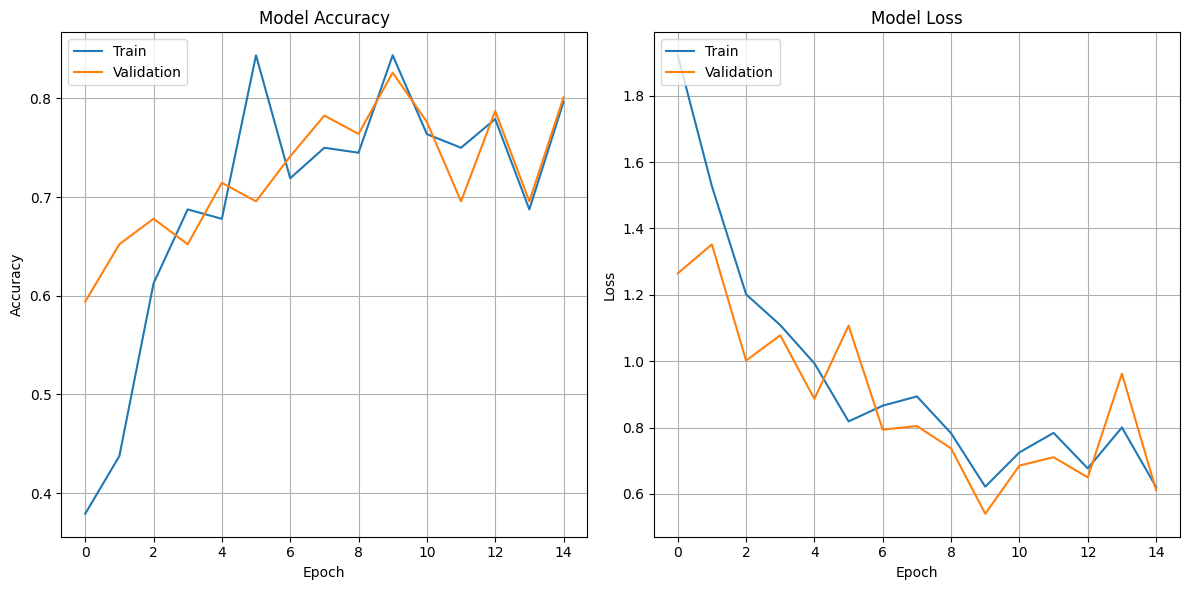

In [24]:
# Setup the ImageDataGenerator with the augmentation options
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of data for validation
)

# Prepare the training and validation generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),  # New image size
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),  # New image size
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

# Model 2: Load and Configure the VGG16 Model with Augmentation
# Load the VGG16 model, pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(128, 128, 3)))

# Freeze the convolutional base
for layer in base_model.layers[:-4]:  # Unfreeze the last 4 layers
    layer.trainable = False

# Create a new model on top
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(18, activation='softmax')(x)  # Ensure this matches the number of classes in your dataset

# This is the model that will be trained
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Configure early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,  # Increase the number of epochs
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"Final validation accuracy: {final_val_accuracy*100:.2f}%, Final validation loss: {final_val_loss:.2f}")

# Save the entire model to a SavedModel directory
model.save('C:\\Users\\ronan\\OneDrive - Atlantic TU\\Year Four\\Sem2\\Gesture Based UI\\vgg16_finetuned_model.keras')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

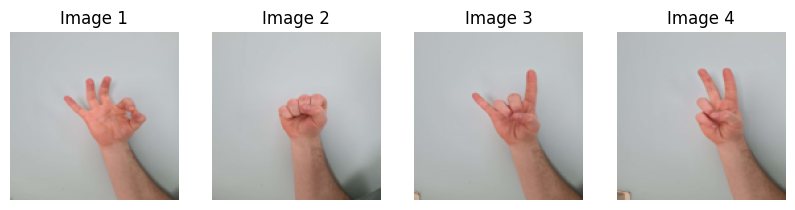

In [97]:
# Function to preprocess the image
def preprocess_image(image_path, img_size):
    img = np.array(Image.open(image_path).resize(img_size)) / 255.0
    img = img.reshape(1, img_size[0], img_size[1], 3)
    return img

# Load and preprocess the personal images
personal_images = [
    r'C:\Users\ronan\OneDrive - Atlantic TU\Year Four\Sem2\Gesture Based UI\GBUIproject2\MyOkay.jpg',
    r'C:\Users\ronan\OneDrive - Atlantic TU\Year Four\Sem2\Gesture Based UI\GBUIproject2\MyFist.jpg',
    r'C:\Users\ronan\OneDrive - Atlantic TU\Year Four\Sem2\Gesture Based UI\GBUIproject2\MyRock.jpg',
    r'C:\Users\ronan\OneDrive - Atlantic TU\Year Four\Sem2\Gesture Based UI\GBUIproject2\MyPeace.jpg'
]

# Preprocess and visualize personal images
plt.figure(figsize=(10, 5))
for i, image_path in enumerate(personal_images):
    img = preprocess_image(image_path, img_size)
    plt.subplot(1, 4, i+1)
    plt.imshow(np.squeeze(img))
    plt.title(f'Image {i+1}')
    plt.axis('off')
plt.show()



In [100]:
# Evaluate on a separate test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


787/787 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step - accuracy: 0.8855 - loss: 0.3853
Test Accuracy: 88.87%


## Using best Model to test on unseen data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


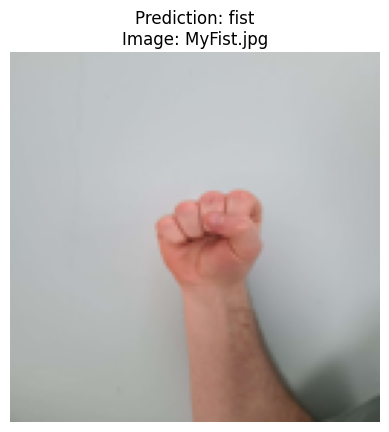

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


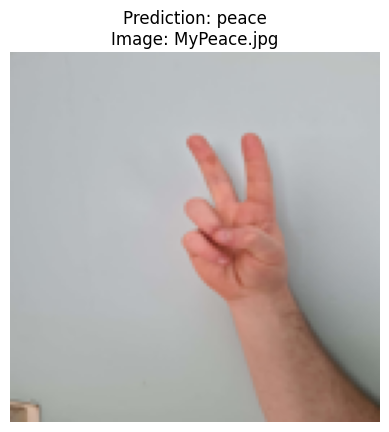

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


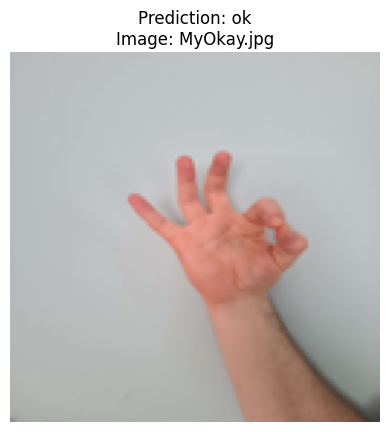

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


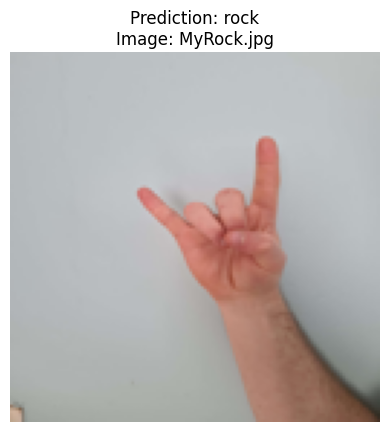

MyFist.jpg Prediction: fist
MyPeace.jpg Prediction: peace
MyOkay.jpg Prediction: ok
MyRock.jpg Prediction: rock


In [102]:

IMAGE_SIZE1 = [128, 128]
class_names = train_dataset.class_names

# Function to predict and print the result
def predict_and_display(image_path, model, class_names):
    image = np.array(Image.open(image_path).resize((IMAGE_SIZE1[0], IMAGE_SIZE1[1])))
    image_reshaped = image.reshape(1, IMAGE_SIZE1[0], IMAGE_SIZE1[1], 3)
    prediction = model.predict(image_reshaped)
    prediction_label = pd.DataFrame(prediction, columns=class_names).idxmax(axis=1).iloc[0]

    plt.imshow(image)
    plt.title(f"Prediction: {prediction_label}\nImage: {image_path}")
    plt.axis('off')
    plt.show()

    return prediction_label

# Predictions
my_image1_prediction = predict_and_display("MyFist.jpg", model, class_names)
my_image2_prediction = predict_and_display("MyPeace.jpg", model, class_names)
my_image3_prediction = predict_and_display("MyOkay.jpg", model, class_names)
my_image4_prediction = predict_and_display("MyRock.jpg", model, class_names)

# Print the predictions
print("MyFist.jpg Prediction:", my_image1_prediction)
print("MyPeace.jpg Prediction:", my_image2_prediction)
print("MyOkay.jpg Prediction:", my_image3_prediction)
print("MyRock.jpg Prediction:", my_image4_prediction)
